# Tutorial: Heater Unit Model with Ideal Property Package



![](heater_2.svg)

In this tutorial, we will heat a liquid mixture of benzene-toluene using a simple heater unit model, and an ideal property package with the phases specified to liquid apriori. The inlet specifications are as follows:

* Flow Rate = 1 kmol/hr
* Mole fraction (Benzene) = 0.4
* Mole fraction (Toluene) = 0.6
* Pressure = 101325 Pa
* Temperature = 353 K

In addition to the inlet specifications, there is one additional unit level specification that needs to be set:
* Option 1: Specify the outlet temperature
* Option 2: Specify the heat duty

Therefore, in this tutorial, we will simulate the following cases:

* Case 1: Compute the heat duty (J/s) required to heat the mixture to 363 K.
* Case 2: Compute the outlet temperature of the mixture when fixing the heat duty to 2 J/s. 

IDAES documentation reference for heater model: https://idaes-pse.readthedocs.io/en/stable/models/heater.html#

## Setting up the problem in IDAES

In [1]:
# Import objects from pyomo package 
from pyomo.environ import ConcreteModel, SolverFactory, value
from pyomo.opt import TerminationCondition, SolverStatus

# Import the main FlowsheetBlock from IDAES. The flowsheet block will contain the unit model
from idaes.core import FlowsheetBlock

# Import idaes logger to set output levels
import idaes.logger as idaeslog

# Create the ConcreteModel and the FlowsheetBlock, and attach the flowsheet block to it.
m = ConcreteModel()

m.fs = FlowsheetBlock(default={"dynamic": False}) # dynamic or ss flowsheet needs to be specified here


# Import the BTX_ideal property package to create a properties block for the flowsheet
from idaes.generic_models.properties.activity_coeff_models import BTX_activity_coeff_VLE

# Add properties parameter block to the flowsheet with specifications
m.fs.properties = BTX_activity_coeff_VLE.BTXParameterBlock(default={"valid_phase":
                                                     'Liq',
                                                     "activity_coeff_model":
                                                     "Ideal"})

2020-06-25 20:17:53 [WARNING] idaes.core.flowsheet_model: DEPRECATED: No units were specified for the time domain. Users should provide unit via the time_units. This will not affect steady-state flowsheets, but for dynamic cases unitless time domains will only work with unitless property packages, and vice versa.


In [2]:
# Import heater unit model from the model library
from idaes.generic_models.unit_models.heater import Heater

# Create an instance of the heater unit, attaching it to the flowsheet
# Specify that the property package to be used with the heater is the one we created earlier.
m.fs.heater = Heater(default={"property_package": m.fs.properties})

# Import the degrees_of_freedom function from the idaes.core.util.model_statistics package
# DOF = Number of Model Variables - Number of Model Constraints
from idaes.core.util.model_statistics import degrees_of_freedom


# Call the degrees_of_freedom function, get intitial DOF
DOF_initial = degrees_of_freedom(m)
print("The initial DOF is {0}".format(DOF_initial))



2020-06-25 20:17:54 [WARNING] idaes.core.property_meta: DEPRECATED: IDAES is moving to using Pyomo Units when defining default units, which are used to automatically determine units of measurement for quantities and convert where necessary. Users are strongly encouraged to convert their property packages to use Pyomo Units obejcts.
The initial DOF is 6


In [3]:
assert DOF_initial == 6

In [4]:
# Fix the BT stream inlet conditions
m.fs.heater.inlet.flow_mol.fix(1*1000/3600) # converting to mol/s as unit basis is mol/s
m.fs.heater.inlet.mole_frac_comp[0, "benzene"].fix(0.4)
m.fs.heater.inlet.mole_frac_comp[0, "toluene"].fix(0.6)
m.fs.heater.inlet.pressure.fix(101325) # Pa
m.fs.heater.inlet.temperature.fix(353) # K

## Case 1: Fix Outlet Temperature

In [5]:
m.fs.heater.outlet.temperature.fix(363)
# Call the degrees_of_freedom function, get final DOF
DOF_final = degrees_of_freedom(m)
print("The final DOF is {0}".format(DOF_final))

The final DOF is 0


In [6]:
assert DOF_final == 0

### Flowsheet Initialization

IDAES includes pre-written initialization routines for all unit models.
The output from initialization can be set to 7 different levels depending on the details required by the user.
In general, when a particular output level is set, any information at that level and above gets picked up by logger. The default level taken by the logger is INFO. 
More information on these levels can be found in the IDAES documentation: 
https://idaes-pse.readthedocs.io/en/latest/logging.html

In [7]:
# Initialize the flowsheet, and set the output at WARNING
m.fs.heater.initialize(outlvl=idaeslog.WARNING)
# From the output it can be inferred that since there are no errors or warnings encountered during initialization, nothing is displayed  

In [8]:
# Initialize the flowsheet, and set the output at INFO_HIGH
m.fs.heater.initialize(outlvl=idaeslog.INFO_HIGH)
# At INFO_HIGH level, details of all the initialization steps are displayed

2020-06-25 20:17:54 [INFO] idaes.init.fs.heater.control_volume.properties_in: Initialization Step 1 skipped.
2020-06-25 20:17:54 [INFO] idaes.init.fs.heater.control_volume.properties_in: Initialization Step 2 optimal - Optimal Solution Found.
2020-06-25 20:17:54 [INFO] idaes.init.fs.heater.control_volume.properties_in: Initialization Step 3 optimal - Optimal Solution Found.
2020-06-25 20:17:54 [INFO] idaes.init.fs.heater.control_volume.properties_in: Initialization Step 4 optimal - Optimal Solution Found.
2020-06-25 20:17:54 [INFO] idaes.init.fs.heater.control_volume.properties_in: Initialization Step 5 optimal - Optimal Solution Found.
2020-06-25 20:17:54 [INFO] idaes.init.fs.heater.control_volume.properties_out: Initialization Step 1 skipped.
2020-06-25 20:17:54 [INFO] idaes.init.fs.heater.control_volume.properties_out: Initialization Step 2 optimal - Optimal Solution Found.
2020-06-25 20:17:54 [INFO] idaes.init.fs.heater.control_volume.properties_out: Initialization Step 3 optimal -

### Obtaining Simulation Results

In [9]:
# Solve the simulation using ipopt
# Note: If the degrees of freedom = 0, we have a square problem
opt = SolverFactory('ipopt')
solve_status = opt.solve(m, tee=True)


Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

In [10]:
# Check if termination condition is optimal
assert solve_status.solver.termination_condition == TerminationCondition.optimal
assert solve_status.solver.status == SolverStatus.ok

### View Results

In [11]:
# Display Heat Duty only
m.fs.heater.heat_duty.display()

heat_duty : Size=1, Index=fs.time
    Key : Lower : Value              : Upper : Fixed : Stale : Domain
    0.0 :  None : 459.10147722222354 :  None : False : False :  Reals


In [12]:
# Display a readable report
m.fs.heater.report()


Unit : fs.heater                                                           Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key       : Value  : Fixed : Bounds
    Heat Duty : 459.10 : False : (None, None)

------------------------------------------------------------------------------------
    Stream Table
                              Inlet     Outlet  
    flow_mol                  0.27778    0.27778
    mole_frac_comp benzene    0.40000    0.40000
    mole_frac_comp toluene    0.60000    0.60000
    temperature                353.00     363.00
    pressure               1.0132e+05 1.0132e+05


In [13]:
import pytest

# Check results
assert m.fs.heater.heat_duty[0].value == pytest.approx(459.10, abs=1e-2)

assert m.fs.heater.outlet.flow_mol[0].value == pytest.approx(0.27778, abs=1e-2)
assert m.fs.heater.outlet.mole_frac_comp[0, "benzene"].value == pytest.approx(0.4, abs=1e-3)
assert m.fs.heater.outlet.mole_frac_comp[0, "toluene"].value == pytest.approx(0.6, abs=1e-3)
assert m.fs.heater.outlet.temperature[0].value == pytest.approx(363, abs=1e-2)
assert m.fs.heater.outlet.pressure[0].value == pytest.approx(101325, abs=1)


## Case 2: Fix Heat Duty

In [14]:
# Fix heat duty and solve the model 
m.fs.heater.outlet.temperature.unfix()
m.fs.heater.heat_duty.fix(459.10147722222354)
solve_status = opt.solve(m, tee=True)

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

In [15]:
# Check if termination condition is optimal
assert solve_status.solver.termination_condition == TerminationCondition.optimal
assert solve_status.solver.status == SolverStatus.ok

In [16]:
# Display outlet temperature only
m.fs.heater.outlet.temperature.display()

_outlet_temperature_ref : Size=1, Index=fs.time
    Key : Lower : Value : Upper : Fixed : Stale : Domain
    0.0 :     0 : 363.0 :  None : False : False : NonNegativeReals


In [17]:
# Display a readable report
m.fs.heater.report()


Unit : fs.heater                                                           Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key       : Value  : Fixed : Bounds
    Heat Duty : 459.10 :  True : (None, None)

------------------------------------------------------------------------------------
    Stream Table
                              Inlet     Outlet  
    flow_mol                  0.27778    0.27778
    mole_frac_comp benzene    0.40000    0.40000
    mole_frac_comp toluene    0.60000    0.60000
    temperature                353.00     363.00
    pressure               1.0132e+05 1.0132e+05


In [18]:
# Check results
assert m.fs.heater.heat_duty[0].value == pytest.approx(459.10, abs=1e-2)

assert m.fs.heater.outlet.flow_mol[0].value == pytest.approx(0.27778, abs=1e-2)
assert m.fs.heater.outlet.mole_frac_comp[0, "benzene"].value == pytest.approx(0.4, abs=1e-3)
assert m.fs.heater.outlet.mole_frac_comp[0, "toluene"].value == pytest.approx(0.6, abs=1e-3)
assert m.fs.heater.outlet.temperature[0].value == pytest.approx(363, abs=1e-2)
assert m.fs.heater.outlet.pressure[0].value == pytest.approx(101325, abs=1)

## Plotting Q vs. Outlet Temperature

In [19]:
# Heat Duty vs Outlet Temperature
import matplotlib.pyplot as plt
import numpy as np

# Unfix the heat duty from case 2
m.fs.heater.heat_duty.unfix()

# Create a list of outlet temperatures for which corresponding heat duty values need to be obtained
outlet_temp_fixed = [91.256405+273.15,
90.828456+273.15,
86.535145+273.15,
89.383218+273.15,
93.973657+273.15,
85.377274+273.15,
92.399101+273.15,
94.151562+273.15,
87.564579+273.15,
88.767855+273.15]

# Fix the outlet temperature values and solve the model to obtain the heat duties
heat_duty = []
for temp in outlet_temp_fixed:
    m.fs.heater.outlet.temperature.fix(temp)
    solve_status=opt.solve(m)
    if solve_status.solver.termination_condition == TerminationCondition.optimal:
        heat_duty.append(m.fs.heater.heat_duty[0].value) 




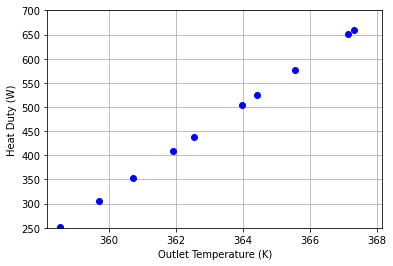

In [20]:
# Plotting the results

plt.figure("Q vs. Temperature")
plt.plot(outlet_temp_fixed,heat_duty,'bo')
plt.xlim(358.15,368.15)
plt.ylim(250,700)
plt.xlabel('Outlet Temperature (K)')
plt.ylabel('Heat Duty (W)')
plt.grid()